In [70]:
# name = 'carSales1'
# name = 'carSales2'
# name = 'Census'
name = 'Emission'

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import os
import numpy as np
import json
current_dir = "C:\\Users\\52497\\Dropbox\\VIS\\Insight\\"
data_folder = current_dir + "Data\\"
result_folder = current_dir + "res\\"

raw_data_path = os.path.join(data_folder, '{}.csv'.format(name))
insight_data_path = os.path.join(result_folder, 'insights_{}.csv'.format(name))


def get_feature_columns():
    insight_df = pd.read_csv(insight_data_path)
    feature_columns = []
    for feature in insight_df.columns:
        if feature == 'breakdown':
            break
        feature_columns.append(feature)
    return feature_columns

feature_columns = get_feature_columns()
converts = {}

for feature in feature_columns:
    converts[feature] = str
raw_data_df = pd.read_csv(raw_data_path, converters = converts)
insight_df = pd.read_csv(insight_data_path, converters = converts)
# 需要把所有的feature 转成string类型以避免后面强制转换成string类型时候，浮点数位数不好处理的问题
insight_df = insight_df[insight_df.insight != 'correlation']
insight_df.drop([i for i in insight_df.columns if 'Correlated' in i], axis=1, inplace=True)
print(insight_df)
if name == 'carSales1':
    raw_data_df['Year'] = raw_data_df['Year'].apply(lambda row: row.split('/')[0])

 # The order is same ot the subspace

for feature in feature_columns:
    raw_data_df[feature] = raw_data_df[feature].astype(str)
    insight_df[feature] = insight_df[feature].astype(str)

feature_count_list = [raw_data_df[feature_columns[i]].value_counts() for i in range(len(feature_columns))]
raw_feature_count = pd.concat(feature_count_list)


fc_template = raw_feature_count.copy().astype(float)
for i in fc_template.index:
    fc_template[i] = 0

insight_types = insight_df['insight_type'].unique()
insights = insight_df['insight'].unique()


            Producer Type Energy Source  Year State      breakdown  \
0                       *             *     *    MS           Year   
1        Industrial Cogen         Other     *     *           Year   
2    Utility Sector Cogen         Other     *     *           Year   
3                       *             *     *    UT           Year   
4                       *             *     *    CO           Year   
..                    ...           ...   ...   ...            ...   
245                     *             *  2005     *  Energy Source   
246                     *             *  2012     *  Energy Source   
247                     *             *     *     *  Producer Type   
248                     *             *  2014     *  Energy Source   
249                     *             *  2007     *  Energy Source   

      breakdown_value       sig    impact      insight insight_type     score  \
0                  -1  0.561615  0.014724        trend        shape  0.008269 

In [71]:
# sub_space_col = list(insight_df['Subspace'])
# array = []
# for idx, raw in enumerate(sub_space_col):
#     array.append(raw.split(';')[:])
# array = np.array(array)

array = np.array(insight_df[feature_columns].values)

for idx, c in enumerate(feature_columns):
    insight_df[c] = array[:,idx]

current_columns = feature_columns + [c for c in insight_df.columns if c not in feature_columns]
insight_df = insight_df[current_columns]
insight_df['id'] = insight_df.index

insight_df['breakdown_value'] = insight_df['breakdown_value'].fillna(-1)
# insight_df['score'] = insight_df['Sig']*insight_df['Impact']
# insight_df = insight_df[insight_df['score'] > 0.005]
# insight_df = insight_df[insight_df['Sig'] > 0.5]

In [72]:
def get_subspace_condition(subspace_dict, feature_columns, df):
    condition = pd.Series(True, index=df.index)
    for feature in feature_columns:
        if subspace_dict[feature] == '*':
            continue
        condition = condition & (df[feature] == subspace_dict[feature])
    return condition

def get_subspace_df(subspace_dict, feature_columns, df):

    condition = get_subspace_condition(subspace_dict, feature_columns, df)
    return df[condition]

# def calc_coverage(row):
#     sub_space_df = get_subspace_df(dict(row), feature_columns, raw_data_df)
#     return len(sub_space_df.index.intersection(raw_data_df.index)) / len(sub_space_df.index.union(raw_data_df.index))

def raw_coverage_embedding(row):
    sub_space_df = get_subspace_df(dict(row), feature_columns, raw_data_df)
    embedding_index = sub_space_df.index.intersection(raw_data_df.index)
    embedding = np.zeros(raw_data_df.shape[0])
    for index in embedding_index:
        embedding[index] = 1
    return embedding

def calc_index_jaccard(df1, df2):
    return len(df1.index.intersection(df2.index)) / len(df1.index.union(df2.index))

# ---------
# rdcE: raw data coverage embedding
# fcpE: feature count percentage embedding

nodes, edges = [], []
for index, insight_row in insight_df.iterrows():
    node_info = dict(insight_row)
    node_info['rdcE'] = list(raw_coverage_embedding(insight_row))
    node_info['sim_distance'] = [0 for i in range(0, insight_df.shape[0])]

    sub_space_df = get_subspace_df(node_info, feature_columns, raw_data_df)
    sub_fcp = fc_template.copy()
    for column in feature_columns:
        feature_value_counts = sub_space_df[column].value_counts()
        for i in feature_value_counts.index:
            sub_fcp[i] =  float(feature_value_counts[i]) / float(raw_data_df.shape[0])
    node_info['fcpE'] = list(sub_fcp)
    nodes.append(node_info)

In [73]:

match_dicts = {}
for feature in feature_columns:
    match_dicts[feature] = nodes[2][feature]

condition = pd.Series(True, index=raw_data_df.index)
for feature in feature_columns:
    if match_dicts[feature] == '*':
        continue
    condition = condition & (raw_data_df[feature] == match_dicts[feature])

In [74]:
for i in range(0, len(nodes)):
    src = nodes[i]
    src_subspace_df = get_subspace_df(src, feature_columns, raw_data_df)
    src['sim_distance'][i] = 1

    for j in range(i+1, len(nodes)):
        dst = nodes[j]
        dst_subspace_df = get_subspace_df(dst, feature_columns, raw_data_df)
        if dst_subspace_df.shape[0] == 0 and src_subspace_df.shape[0]==0:
            print(i,j)
        distance = calc_index_jaccard(src_subspace_df, dst_subspace_df)
        edges.append({'source': src['id'], 'target':dst['id'], 'jaccard_index': distance})
        src['sim_distance'][j] = distance
    print(i)
print('Finish')

graph = {
    'nodes': nodes,
    'edges': edges,
    'featrues': feature_columns
}



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
Finish


In [75]:
from sklearn.manifold import MDS, SpectralEmbedding, Isomap, TSNE
import seaborn as sns


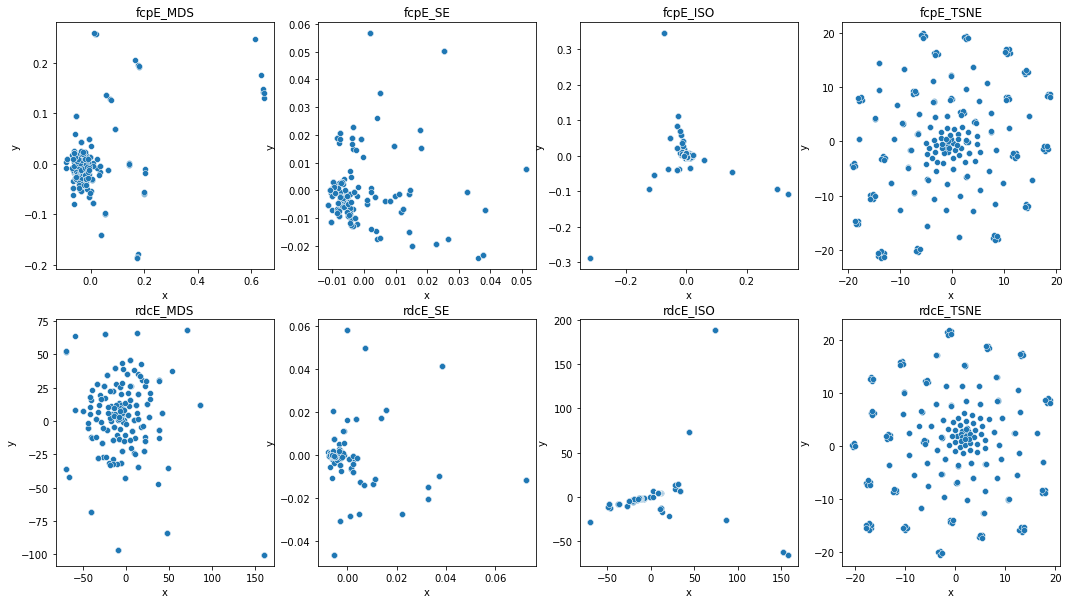

In [76]:
# Calculate the feature coverage percentage: fcpE
fcpE_feature_category = 'fcpE'
impact_weight = 0.3
fcpE_feature_array = np.array([node[fcpE_feature_category]+ [node['impact'] * impact_weight] for node in nodes])


fcpE_MDS_embedded = MDS(n_components=2, metric = True).fit_transform(fcpE_feature_array)
fcpE_SE_embedded = SpectralEmbedding(n_components=2).fit_transform(fcpE_feature_array)
fcpE_ISO_embedded = Isomap(n_components=2).fit_transform(fcpE_feature_array)
fcpE_TSNE_embedded = TSNE(n_components=2, perplexity=30).fit_transform(fcpE_feature_array)

# Calculate the raw data coverage: rdcE
rdcE_feature_category = 'rdcE'
impact_weight = 0.3
rdcE_feature_array = np.array([node[rdcE_feature_category]+ [node['impact'] * impact_weight] for node in nodes])
rdcE_MDS_embedded = MDS(n_components=2, metric = True).fit_transform(rdcE_feature_array)
rdcE_SE_embedded = SpectralEmbedding(n_components=2).fit_transform(rdcE_feature_array)
rdcE_ISO_embedded = Isomap(n_components=2).fit_transform(rdcE_feature_array)
rdcE_TSNE_embedded = TSNE(n_components=2, perplexity=30).fit_transform(rdcE_feature_array)

for i, node in enumerate(nodes):
    node['{}_{}'.format(fcpE_feature_category, 'mds')] = fcpE_MDS_embedded[i].tolist()
    node['{}_{}'.format(fcpE_feature_category, 'se')] = fcpE_SE_embedded[i].tolist()
    node['{}_{}'.format(fcpE_feature_category, 'iso')] = fcpE_ISO_embedded[i].tolist()
    node['{}_{}'.format(fcpE_feature_category, 'tsne')] = fcpE_TSNE_embedded[i].tolist()
    [node['x'], node['y']] = fcpE_TSNE_embedded[i].tolist()

    node['{}_{}'.format(rdcE_feature_category, 'mds')] = rdcE_MDS_embedded[i].tolist()
    node['{}_{}'.format(rdcE_feature_category, 'se')] = rdcE_SE_embedded[i].tolist()
    node['{}_{}'.format(rdcE_feature_category, 'iso')] = rdcE_ISO_embedded[i].tolist()
    node['{}_{}'.format(rdcE_feature_category, 'tsne')] = rdcE_TSNE_embedded[i].tolist()


fig, axs = plt.subplots(2, 4)
fig.set_size_inches(18,10)
sns.scatterplot(data=pd.DataFrame(fcpE_MDS_embedded, columns = ['x', 'y']), x="x", y="y", ax=axs[0][0]).set_title('fcpE_MDS')
sns.scatterplot(data=pd.DataFrame(fcpE_SE_embedded, columns = ['x', 'y']), x="x", y="y", ax=axs[0][1]).set_title('fcpE_SE')
sns.scatterplot(data=pd.DataFrame(fcpE_ISO_embedded, columns = ['x', 'y']), x="x", y="y", ax=axs[0][2]).set_title('fcpE_ISO')
sns.scatterplot(data=pd.DataFrame(fcpE_TSNE_embedded, columns = ['x', 'y']), x="x", y="y", ax=axs[0][3]).set_title('fcpE_TSNE')

sns.scatterplot(data=pd.DataFrame(rdcE_MDS_embedded, columns = ['x', 'y']), x="x", y="y", ax=axs[1][0]).set_title('rdcE_MDS')
sns.scatterplot(data=pd.DataFrame(rdcE_SE_embedded, columns = ['x', 'y']), x="x", y="y", ax=axs[1][1]).set_title('rdcE_SE')
sns.scatterplot(data=pd.DataFrame(rdcE_ISO_embedded, columns = ['x', 'y']), x="x", y="y", ax=axs[1][2]).set_title('rdcE_ISO')
sns.scatterplot(data=pd.DataFrame(rdcE_TSNE_embedded, columns = ['x', 'y']), x="x", y="y", ax=axs[1][3]).set_title('rdcE_TSNE')

graph['insights'] = list(insights)
graph['insight_types'] = list(insight_types)
with open('{}insight_graph_{}.json'.format(current_dir, name), 'w') as output_file:
    for node in graph['nodes']:
        del node['rdcE']
        del node['sim_distance']
        del node['fcpE']
    json.dump(graph, output_file)
